In [98]:
from FundData import multi_request
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as sco
from datetime import datetime
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
funds = ['090010','100038','310398','003318']
#  310398  -->  申万菱信沪深300价值指数
#  090010  -->  大成中证红利指数A
#  100038  -->  富国沪深300增强
#  003318  -->  景顺长城中证500低波动

In [25]:
data = multi_request(funds)

In [26]:
data.date = data.date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
data.nav = data.nav.apply(lambda x:float(x))
data.head()

,date,nav,percentage,value,code
0,2019-08-29,0.9249,-0.25,0.9249,003318
1,2019-08-28,0.9272,-0.46,0.9272,003318
2,2019-08-27,0.9315,1.28,0.9315,003318
3,2019-08-26,0.9197,-0.49,0.9197,003318
4,2019-08-23,0.9242,-0.05,0.9242,003318


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7531 entries, 0 to 7530
Data columns (total 5 columns):
date          7531 non-null datetime64[ns]
nav           7531 non-null float64
percentage    7527 non-null object
value         7531 non-null object
code          7531 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 294.3+ KB


In [41]:
df = data.set_index('date')

In [42]:
df.tail()

,nav,percentage,value,code
date,,,,
2010-03-12,0.999,-0.20,0.9990,090010
2010-03-05,1.001,-0.20,1.0010,090010
2010-02-26,1.003,0.10,1.0030,090010
2010-02-12,1.002,0.30,1.0020,090010
2010-02-05,0.999,NaN,0.9990,090010


In [43]:
table = df.pivot(columns='code',values='nav')
table.dropna(axis=0,how='any',inplace=True)
table.head()

code,003318,090010,100038,310398
date,,,,
2017-03-03,1.0000,1.510,1.496,1.2667
2017-03-10,0.9898,1.509,1.497,1.2709
2017-03-17,0.9935,1.519,1.503,1.2763
2017-03-20,0.9955,1.526,1.505,1.2786
2017-03-21,0.9994,1.540,1.512,1.2875


Text(0, 0.5, 'price in ￥')

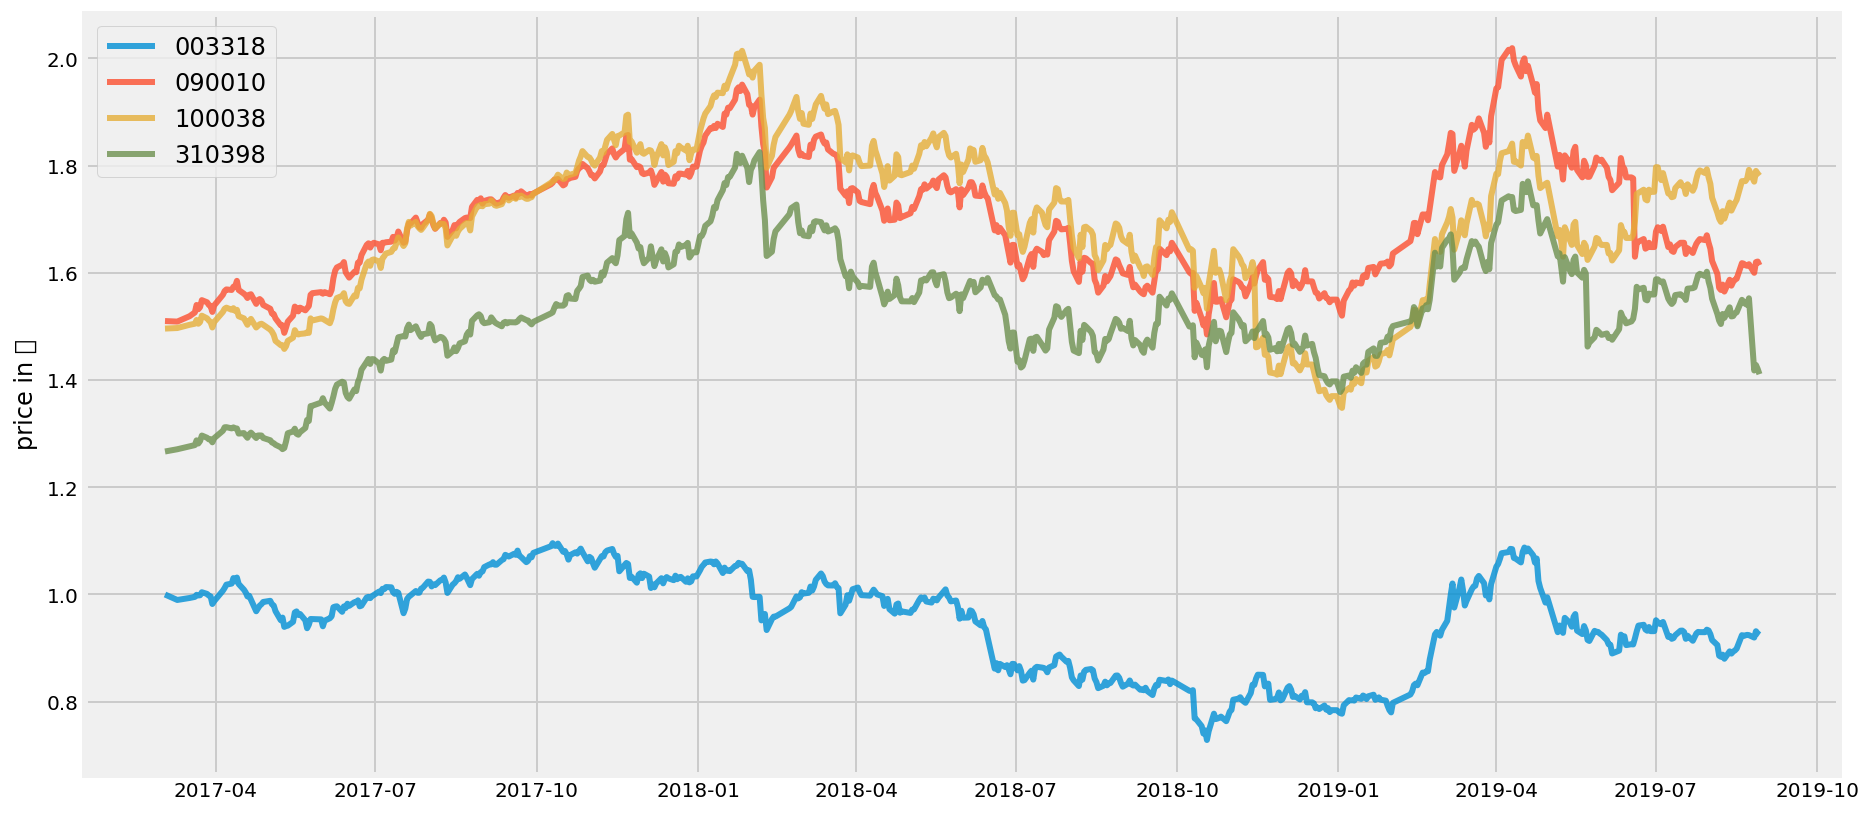

In [46]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in ￥')

In [47]:
returns = table.pct_change()

Text(0, 0.5, 'daily returns')

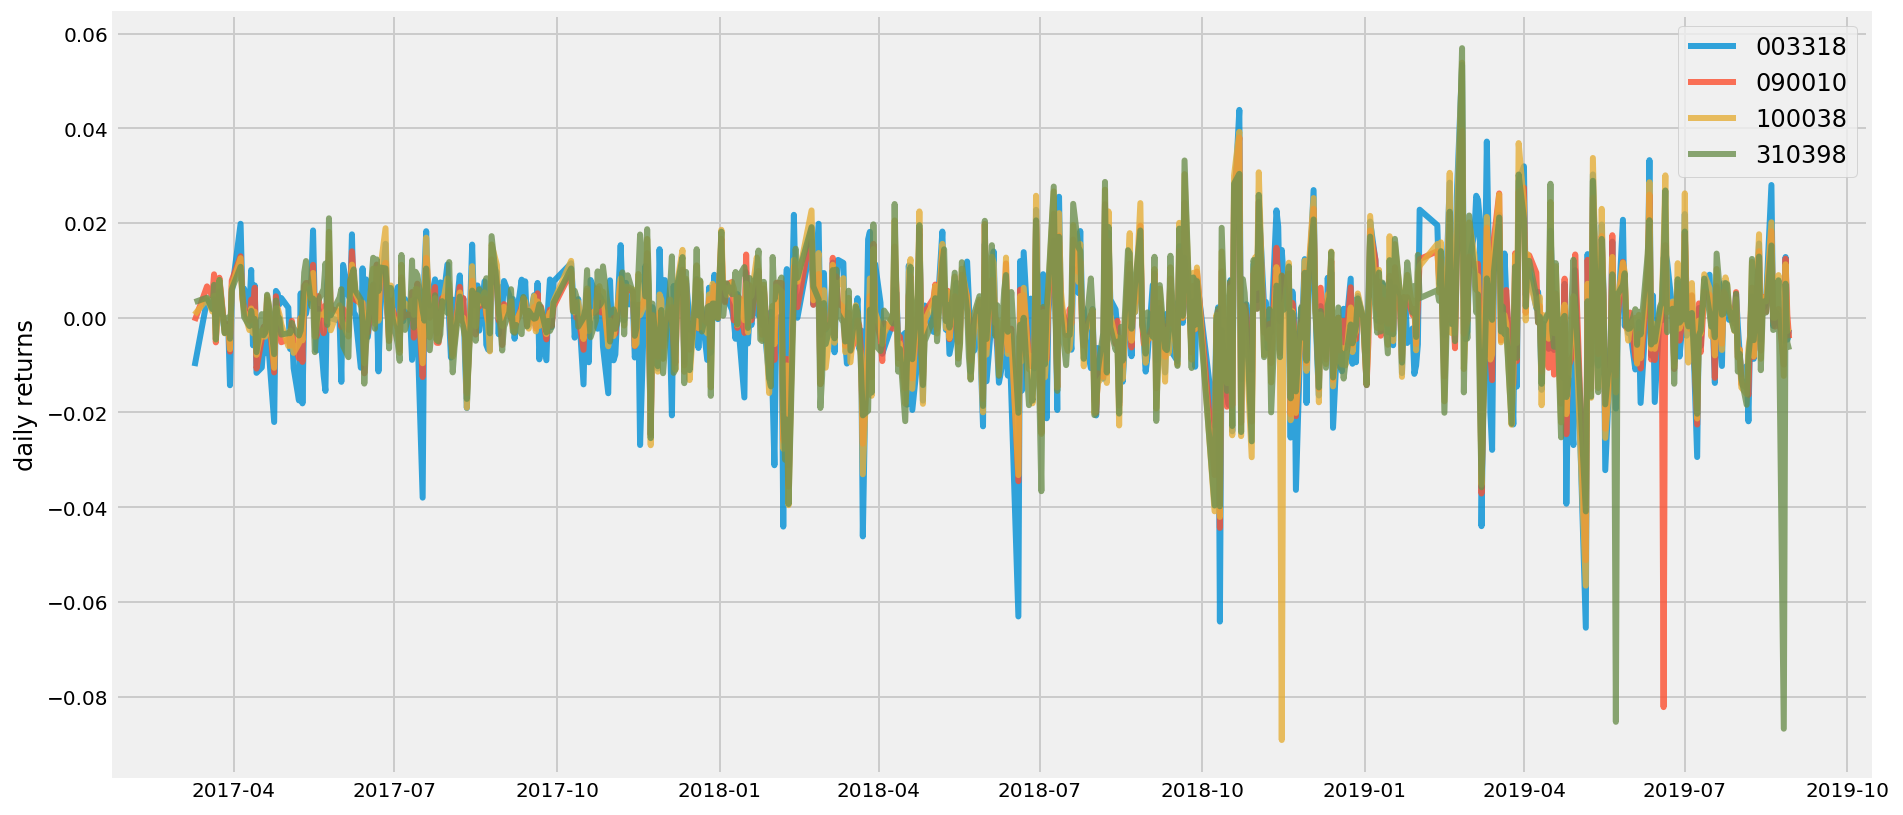

In [48]:
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [49]:
returns.head()

code,003318,090010,100038,310398
date,,,,
2017-03-03,NaN,NaN,NaN,NaN
2017-03-10,-0.010200,-0.000662,0.000668,0.003316
2017-03-17,0.003738,0.006627,0.004008,0.004249
2017-03-20,0.002013,0.004608,0.001331,0.001802
2017-03-21,0.003918,0.009174,0.004651,0.006961


In [75]:
mean_returns = returns.mean()
num_portfolios = 100000   # w我们模拟出10万次随机资产组合
cov_matrix = returns.cov()  #  求收益协方差矩阵
risk_free_rate = 0.0178   # 无风险利率暂定为 1.78%

In [51]:
def portfolio_annualised_performance(weights,mean_returns,cov_matrix):
    # 假设一年有252个交易日
    returns = np.sum(mean_returns * weights) * 252  
    std = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights))) * np.sqrt(252)
    
    return std,returns 

In [82]:
def random_portfolios(num_portfolios,mean_returns,cov_matrix,risk_free_rate):
    #  这个函数的目的是为了产生 weights_record, results
    results = np.zeros((3,num_portfolios))  
    # 三行分别记录 portfolio_std_dev、portfolio_return、portfolio_sharp_ratio
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        portfolio_std_dev,portfolio_return = portfolio_annualised_performance(weights,mean_returns,cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
    return results,weights_record

In [95]:
def display_simulated_ef_with_random(mean_returns,cov_matrix,num_portfolios,risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns,cov_matrix,risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp,rp = results[0,max_sharpe_idx],results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min,rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print('-'*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print('Annualised Return:',round(rp,2))
    print('Annualised Volatility',round(sdp,2))
    print('\n')
    print(max_sharpe_allocation)
    print('-'*80)
    print('Minimum Volatility Portfolio Allocation\n')
    print('Annualied Return:',round(rp_min,2))
    print('Annualised Volatility:',round(sdp_min,2))
    print('\n')
    print(min_vol_allocation)

    plt.figure(figsize=(10,7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu',marker='o',s=10,alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,c='r',marker='*',s=300,label='Maximum Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,c='g',marker='*',s=300,label='Minimum Volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility 0.19


code        003318  090010  100038  310398
allocation       1       0      97       2
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualied Return: 0.04
Annualised Volatility: 0.16


code        003318  090010  100038  310398
allocation      11      66       1      22


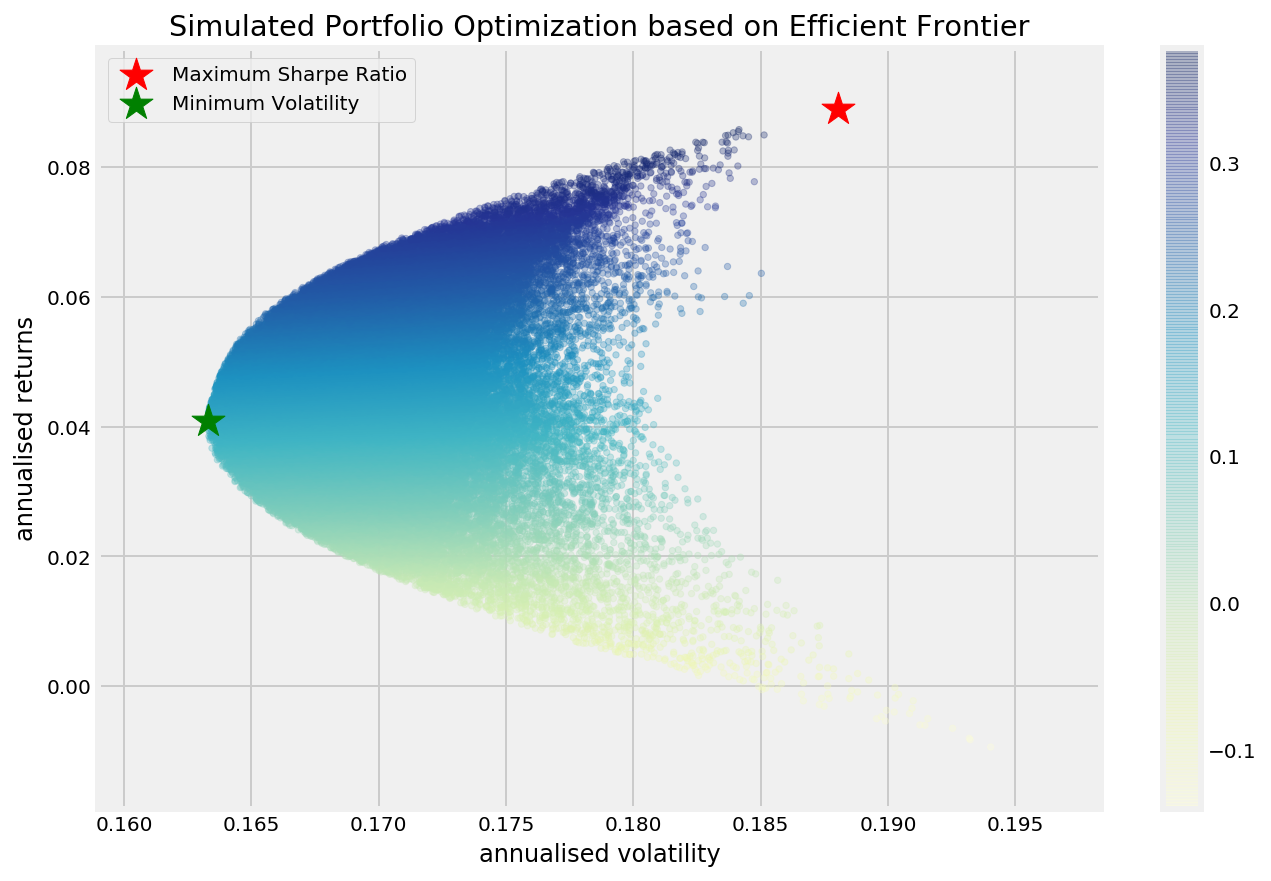

In [96]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

接下来采取类似Excel中Solver的做法来得到最优的资产组合配置

In [106]:
def neg_sharpe_ratio(weights,mean_returns,cov_matrix,risk_free_rate):
    #  这个函数的目的时产生Sharpe的负值
    p_var,p_ret = portfolio_annualised_performance(weights,mean_returns,cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns,cov_matrix,risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns,cov_matrix,risk_free_rate)
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({'type':'eq','fun':lambda x: np.sum(x) - 1})
    result = sco.minimize(neg_sharpe_ratio,num_assets * [1/num_assets,],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

In [107]:
def portfolio_volatility(weights,mean_returns,cov_matrix):
    return portfolio_annualised_performance(weights,mean_returns,cov_matrix)[0]

def min_variance(mean_returns,cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns,cov_matrix)
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({'type':'eq','fun':lambda x: np.sum(x) - 1})
    result = sco.minimize(portfolio_volatility,num_assets * [1/num_assets,],args=args,method='SLSQP',constraints=constraints,bounds=bounds)
    
    return result


In [102]:
def efficient_return(mean_returns,cov_matrix,target):
    num_assets = len(mean_returns)
    args = (mean_returns,cov_matrix)
    
    def portfolio_return(weights):
        return portfolio_annualised_performance(weights,mean_returns,cov_matrix)[1]
    
    constraints = ({'type':'eq','fun':lambda x: portfolio_return(x) - target},{'type':'eq','fun':lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets * [1/num_assets,],args=args,method='SLSQP', bounds=bounds,constraints=constraints)
    
    return result

def efficient_frontier(mean_returns,cov_matrix,returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns,cov_matrix,ret))
    return efficients

In [114]:
def display_calculated_ef_with_random(mean_returns,cov_matrix,num_portfolios,risk_free_rate):
    results,_ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns,cov_matrix,risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    # max_sharpe会返回很多内容，但是x为我们需要的weights
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation
    
    min_vol = min_variance(mean_returns,cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, rp, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.19


code        003318  090010  100038  310398
allocation     0.0     0.0   100.0     0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.04
Annualised Volatility: 0.16


code        003318  090010  100038  310398
allocation   11.64   65.89     0.0   22.46


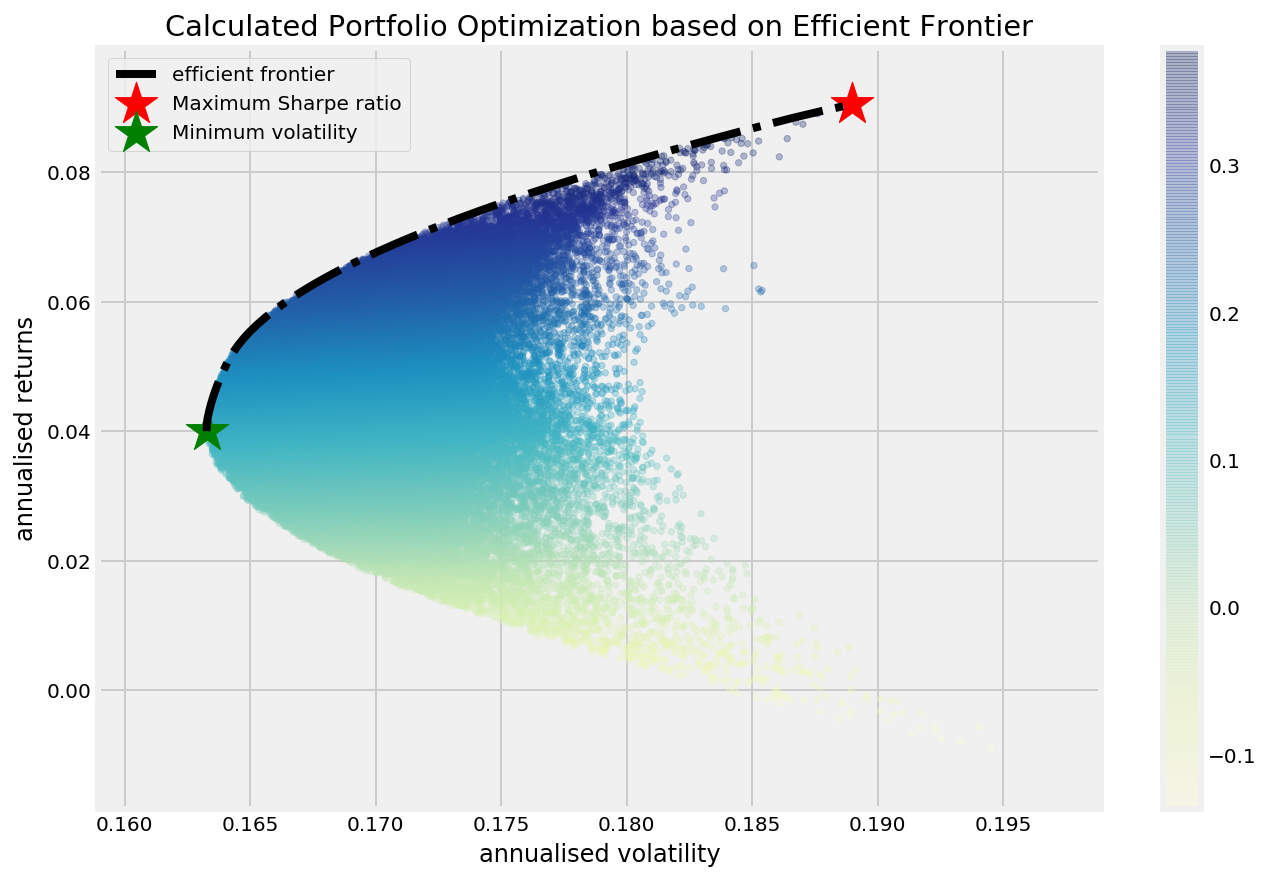

In [115]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [120]:
def display_ef_with_selected(mean_returns,cov_matrix,risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)  # 年化volatility
    an_rt = mean_returns * 252  # 年化 return
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    print("-"*80)
    print("Individual Fund Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig,ax = plt.subplots(figsize=(10,7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    
    for i, txt in enumerate(table.columns):
        ax.annotate(txt,(an_vol[i],an_rt[i]),xytext=(10,0),textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, rp, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.19


code        003318  090010  100038  310398
allocation     0.0     0.0   100.0     0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.04
Annualised Volatility: 0.16


code        003318  090010  100038  310398
allocation   11.64   65.89     0.0   22.46
--------------------------------------------------------------------------------
Individual Fund Returns and Volatility

003318 : annuaised return -0.01 , annualised volatility: 0.2
090010 : annuaised return 0.04 , annualised volatility: 0.17
100038 : annuaised return 0.09 , annualised volatility: 0.19
310398 : annuaised return 0.06 , annualised volatility: 0.19
--------------------------------------------------------------------------------


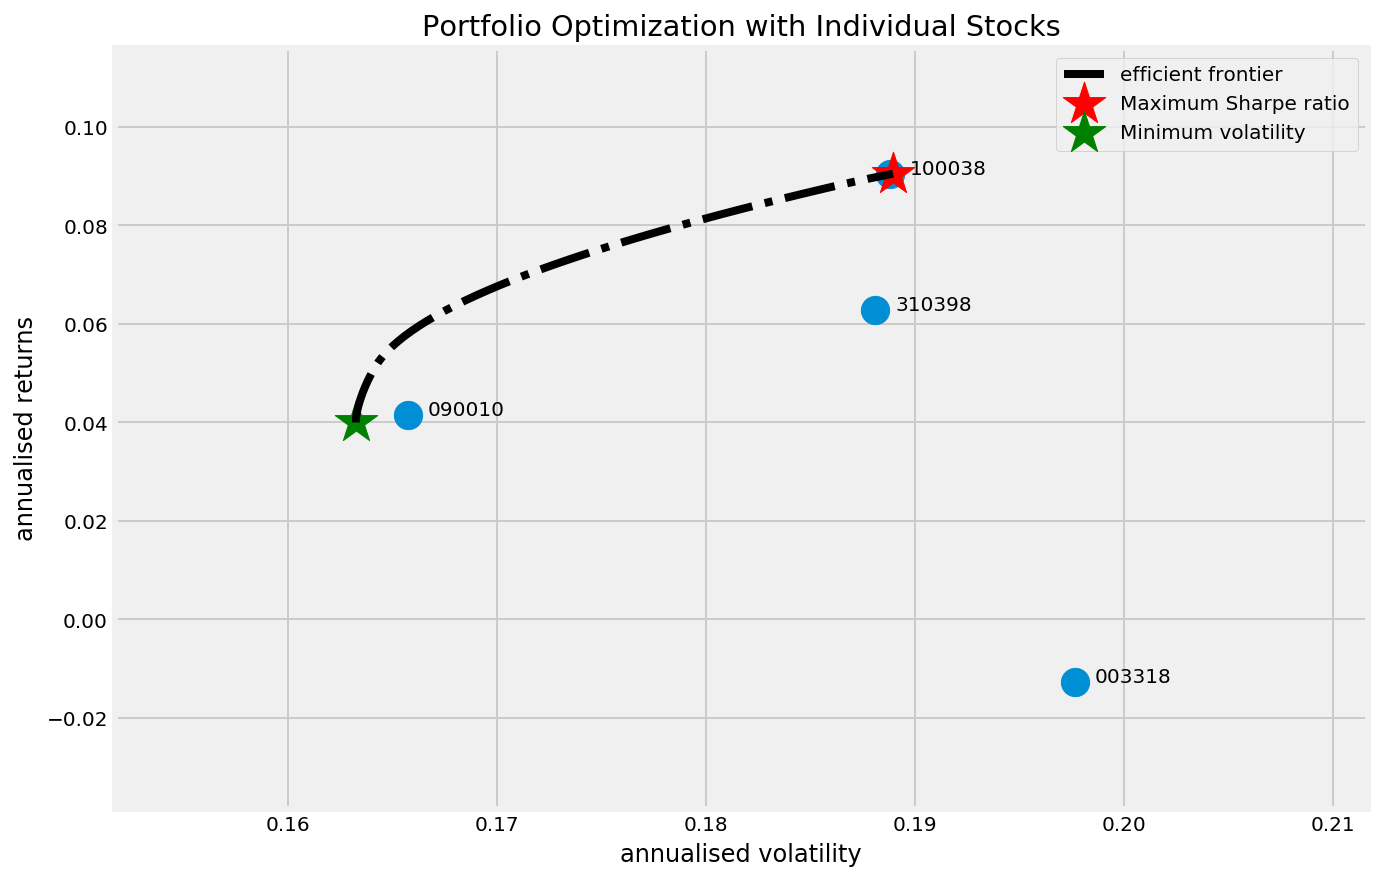

In [121]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)